In [2]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [3]:
import cv2 as cv
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import pandas as pd
import ast
import numpy as np

from utils import dataset_CDD_CESM, patient_CDD

# CDD-CESM



This dataset is an Egyptian dataset composed of 2006 images IN TOTAL, composed of low-energy and constrast-enhanced spectral mamography, aka dual energy.

- 1003 low-energy images
- 1003 CESM

The number of patients is 326. Usually one patient has 8 images:
- 4 images per modality
    - 2 lateralities (L, R) and 2 views (CC, MLO)

Nevertheless, there are some exceptions so the number of total images is not the total hypothetic maximum 2068.

Besides the images we have:
- ROI of the findings: coordinates of the geometrical figure (ellipse, poligon, etc.)
- Biopsy results: benign, malignant.
- finding type: mass, asymmetry, 

## Can CCD-CESM be combined with the INCan DE dataset?
The project should be able to go by itself (no need of additional dataset) but it could be a nice addition to have another underrepresented population (mexican) in the study.

### Similarities
- Both dataset are, in theory, from the <u> same clincial protocol</u>, so it should be possible.
- Both datasets contain handmade ROI segmentations of the findings.
    - Which findings?
- Both dataset seem to have the presubstraction images UNREGISTERED.
    - Important to kepe in mind when using the ROI coordinates.

# Differences
- The mexican dataset have the raw images available, so all the original pixel intensities are available. The egyptian dataset has the images already preprocessed to 8bits.
- The egyptian dataset has black background, therefore has send the negative pixel intensities into a special value (zero?), or map inverselly towards 255. In any case, the images seem to be only showing the contrast-uptake, which is essential for detection.

# Annotations

- We have annotations for basically all patients,and both modalities!<br>
    It is important to remember that not all annotations are from masses so probably the number of images to be used will be less than the total number of images...

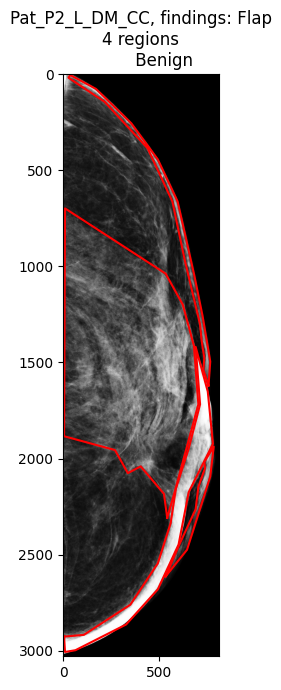

In [4]:
dataset = dataset_CDD_CESM()
pat_example = patient_CDD(patient_id=2, dataset=dataset)

view = 'CC'
mode = 'low-energy'
laterality = 'L'

pat_example.set_image(view=view, mode=mode, laterality=laterality)
image = pat_example.get_array(flip=False, plot=False)
pat_example.plot_annotations(flip=False)

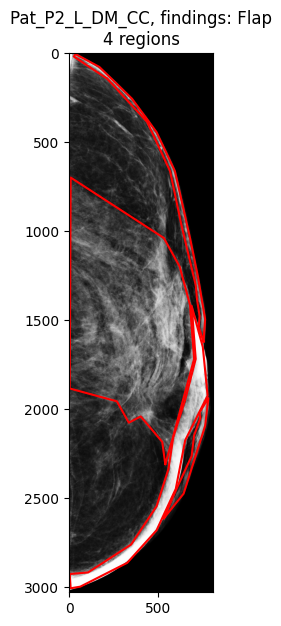

In [5]:
fig, ax = plt.subplots(1,1, figsize=(14,7))
ax.imshow(image)
ax.set_title(f'Pat_{pat_example.image_path.stem}, findings: {pat_example.image_findings}\n{pat_example.image_num_annotations} regions')
for region_num in range(pat_example.image_num_annotations):
    dic_ex = pat_example.image_annotations[pat_example.image_annotations.region_id==region_num].region_shape_attributes.values[0]
    # plot annotation
    if dic_ex['name'] in ['ellipse','circle']:
        center, axes = pat_example.ellipse_reader(dic_ex)
        ax.add_patch(Ellipse(center, 2*axes[0], 2*axes[1], fill=False, edgecolor='r'))
    elif dic_ex['name']=='polygon':
        vertices = pat_example.polygon_reader(dic_ex)
        ax.plot(vertices[:,0], vertices[:,1], 'r')
    elif dic_ex['name']=='point':
        center = pat_example.point_reader(dic_ex)
        ax.scatter(center[0], center[1], c='r', s=10)

# Detecting patients with lesion

WHich images can be used as "lesion positive"?<br>
There are diverse types of lesion in this dataset and only the DBT-challenge-like lesions should be used.<br>
- First, DBT used biopsy proven lesions.
- According to Martí, they are masses


In [15]:
dataset = dataset_CDD_CESM()
dataset.metadata = dataset.metadata[dataset.metadata['Type']=='CESM'].reset_index(drop=True)
# dataset.metadata['Pathology Classification/ Follow up'].value_counts().plot(kind='bar')
# rmeove normal cases
dataset.metadata = dataset.metadata[dataset.metadata['Pathology Classification/ Follow up']!='Normal']
dataset.metadata.Findings.value_counts()

Findings
Non enhancement                                                              62
Non enhancement                                                              29
Heterogenously enhancing mass                                                23
Segmental non mass enhancement                                               18
Foci of enhancement                                                          17
                                                                             ..
Irregular enhancing mass                                                      1
Flap                                                                          1
Multiple heterogenously enhancing masses with irregular margin                1
Faint retroareolar enhancement                                                1
Heterogenously enhancing mass with speculated margin and ductal extension     1
Name: count, Length: 161, dtype: int64

In [27]:
# get position were Tags contain 'mass
dataset.metadata[dataset.metadata.Tags.str.contains('mass')]['Patient_ID'].value_counts()

Patient_ID
274    4
18     4
295    4
66     4
122    4
      ..
108    1
95     1
86     1
77     1
1      1
Name: count, Length: 198, dtype: int64